# Validate Motion State

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

<module 'fetch_data' from '/home/tyler/Documents/Matt3r/IMU_validation/fetch_data.py'>

Select Data

In [2]:
# Hamid data
start_date_str = '2023-06-28'
end_date_str = '2023-06-28'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

In [ ]:
# Amir M data
start_date_str = '2023-06-27'
end_date_str = '2023-06-27'
organization_id = 'amirm'
can_k3y_id = 'c9a6b512'
imu_k3y_id = 'c9a6b512'

Get the CAN Server Data

In [3]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

Get the IMU Data

In [23]:
# use if we have clock data
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)

Correct the Rotation Matrix for Hamid's Data

In [24]:
GLOVE_TO_CONSOLE_MTX = np.array([[0, 0, 1], [0.0856, 0.9963, 0], [-0.9963, 0.0856, 0]])
S3_K3Y_VEH_ROT_MTX_CONSOLE = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
S3_K3Y_VEH_ROT_MTX = np.matmul(S3_K3Y_VEH_ROT_MTX_CONSOLE, GLOVE_TO_CONSOLE_MTX)
# CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

az = 9.835
# ay = 0.835
ay = 0.987
g = np.sqrt(az**2 + ay**2)
TILT_ROT = np.array([[1, 0, 0], [0, az/g, -ay/g], [0, ay/g, az/g]])

CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@TILT_ROT@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

if organization_id == 'hamid':
    acc_np = imu_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
    vehicle_ac = np.matmul(CORRECTION_MATRIX, acc_np[:, 1:].T)
    vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
    imu_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

Filter Out Warmup Time

In [6]:
warmup_start = 1687886372
warmup_end = 1687886435
imu_df = imu_df[(imu_df['correct_timestamp'] <= warmup_start) | (imu_df['correct_timestamp'] >= warmup_end)]

Get Stationary State Data Metrics

In [25]:
# stitching together all stationary state data
imu_ss_states = []
can_ss_states = []
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
    can_ss_states.append(can_df[(can_df['timestamp'] >= ss_start_time) 
                        & (can_df['timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)
can_ss_df = pd.concat(can_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["lr_acc"].mean()}')
print(f'can max: {can_ss_df["lr_acc"].max()}')
print(f'can min: {can_ss_df["lr_acc"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["bf_acc"].mean()}')
print(f'can max: {can_ss_df["bf_acc"].max()}')
print(f'can min: {can_ss_df["bf_acc"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print(f'can mean: {can_ss_df["vert_acc"].mean()}')
print(f'can max: {can_ss_df["vert_acc"].max()}')
print(f'can min: {can_ss_df["vert_acc"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
can_norm = np.sqrt(can_ss_df['lr_acc']**2 + can_ss_df['bf_acc']**2 + can_ss_df['vert_acc']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')
print(f'can mean: {can_norm.mean()}')
print(f'can max: {can_norm.max()}')
print(f'can min: {can_norm.min()}')

left/right acceleration:
imu mean: 0.0018329790546088162
imu max: 0.044729774404467446
imu min: -0.03542969559553255
can mean: 0.10623880179171333
can max: 40.00875
can min: -20.8

back/from acceleration:
imu mean: 0.013968707018422701
imu max: 0.13758469372452883
imu min: -0.10408165510753443
can mean: 0.12404675251959688
can max: 27.333750000000002
can min: -0.04625

vertical acceleration:
imu mean: 0.07364296316169454
imu max: 0.13129749187388973
imu min: 0.012098549466505322
can mean: -0.04689389697648375
can max: 0.37125
can min: -37.12

normalized acceleration:
imu mean: 0.0872163553812494
imu max: 0.16807761104131727
imu min: 0.02652278512040293
can mean: 0.3337561761774097
can max: 46.591065147327335
can min: 0.026040833319999575


In [11]:
# driving state metrics

dr_df = imu_df
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    dr_df = dr_df[(dr_df['correct_timestamp'] <= ss_start_time) | (dr_df['correct_timestamp'] >= ss_end_time)]

print('left/right acceleration:')
print(f'imu mean: {dr_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {dr_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {dr_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(dr_df['lr_acc(m/s^2)']**2 + dr_df['bf_acc(m/s^2)']**2 + dr_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: -0.00307689648285647
imu max: 6.32931139896168
imu min: -4.045026772044387

back/from acceleration:
imu mean: 0.005619896057330629
imu max: 7.758340552249572
imu min: -4.16723471812193

vertical acceleration:
imu mean: 0.06687214035589767
imu max: 6.977617408535616
imu min: -3.6047239625559415

normalized acceleration:
imu mean: 0.08166970638729569
imu max: 11.017119323268066
imu min: 0.007551239919562279


Filter Only Driving States

1


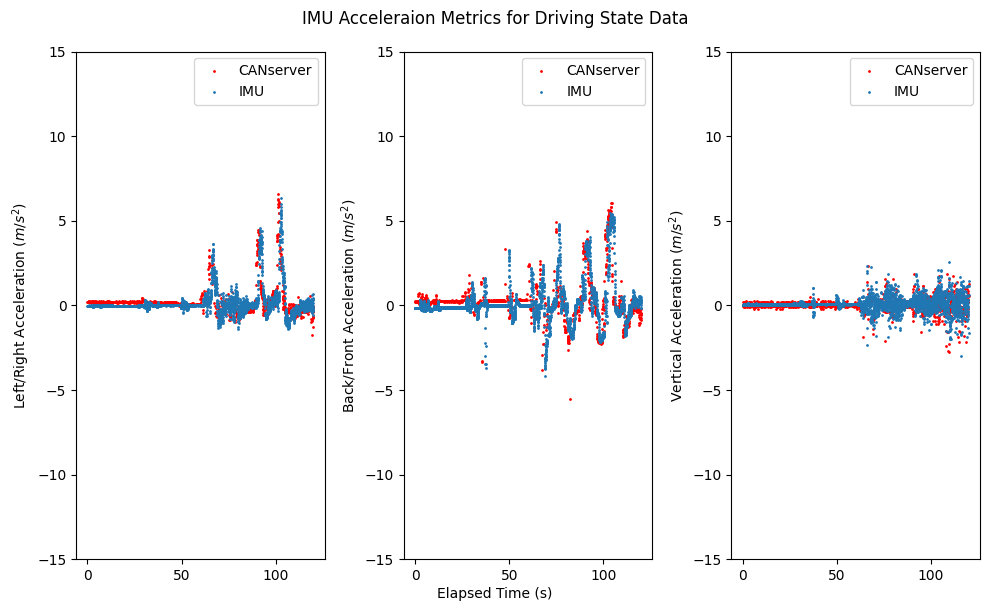

2


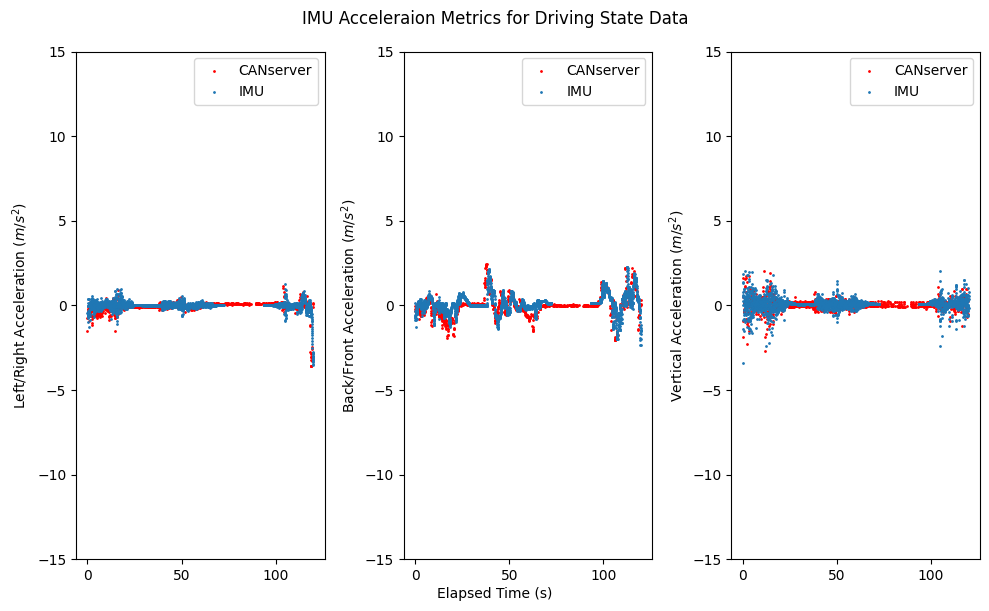

3


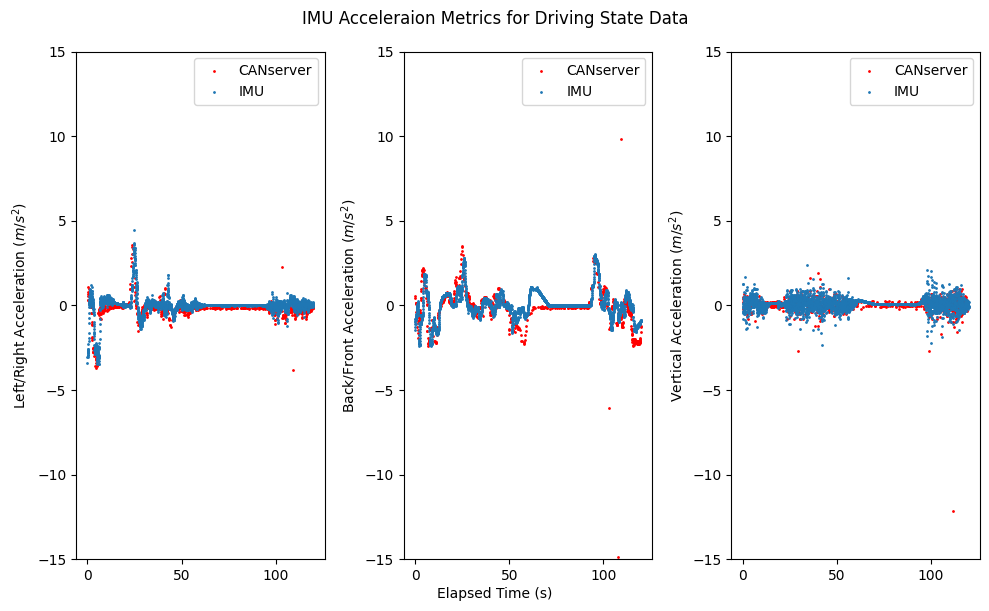

4


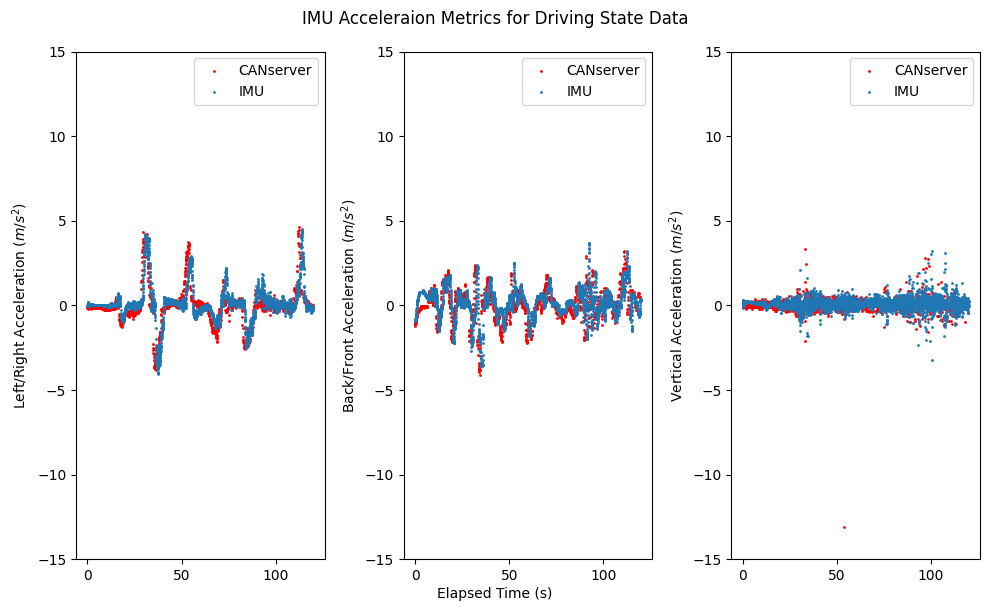

5


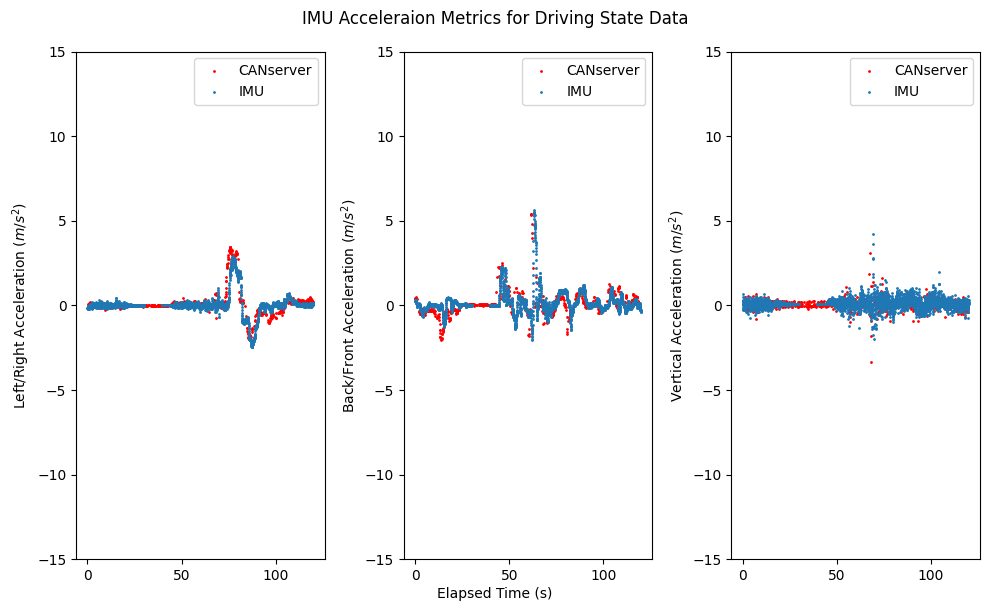

6


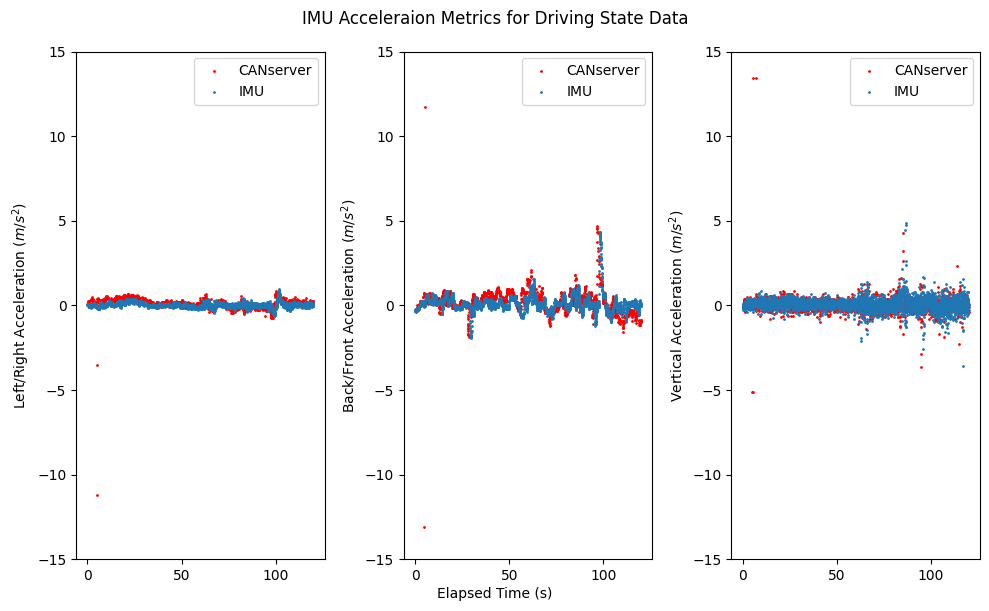

7


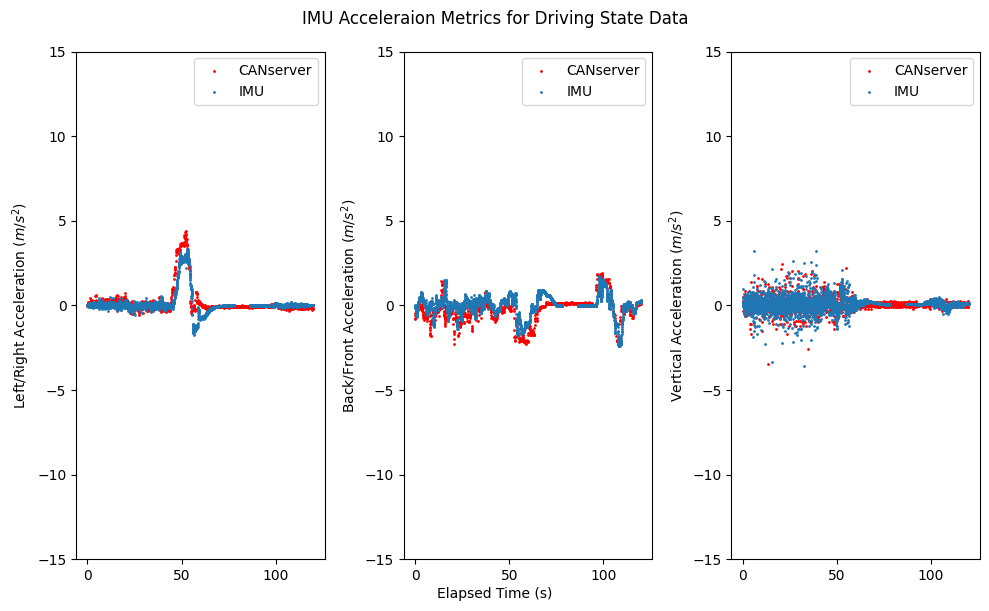

8


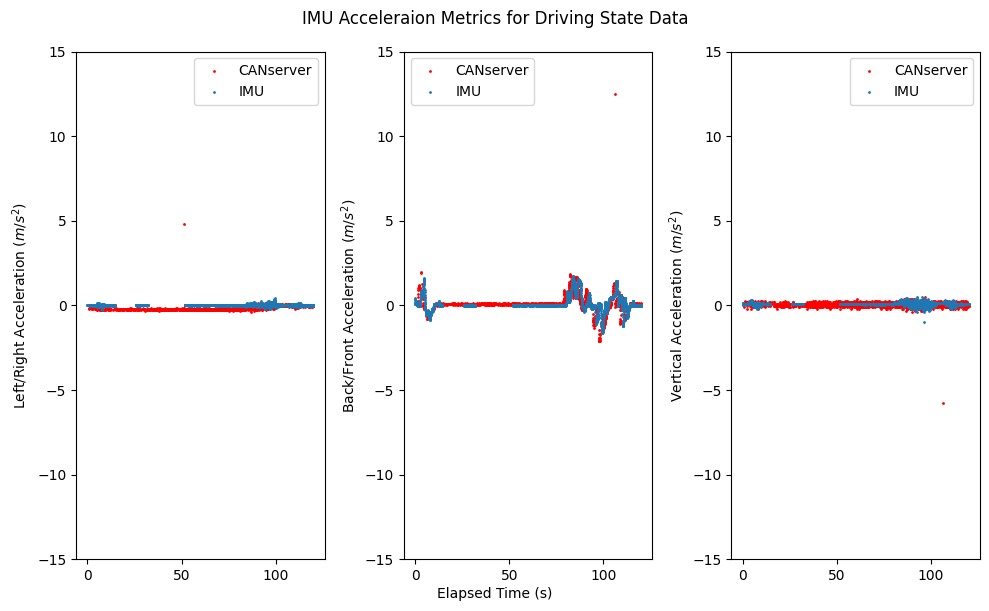

9


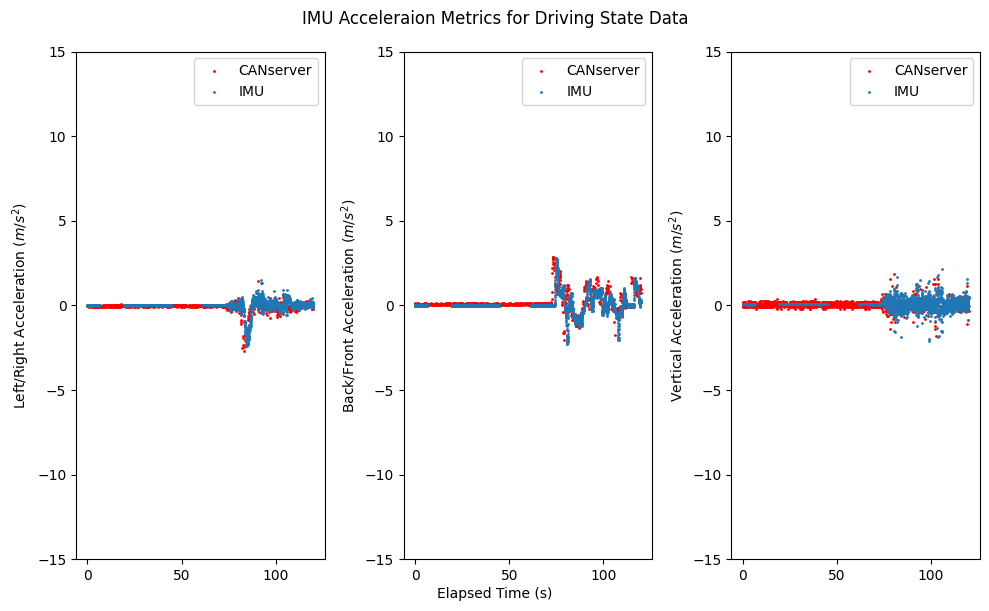

10


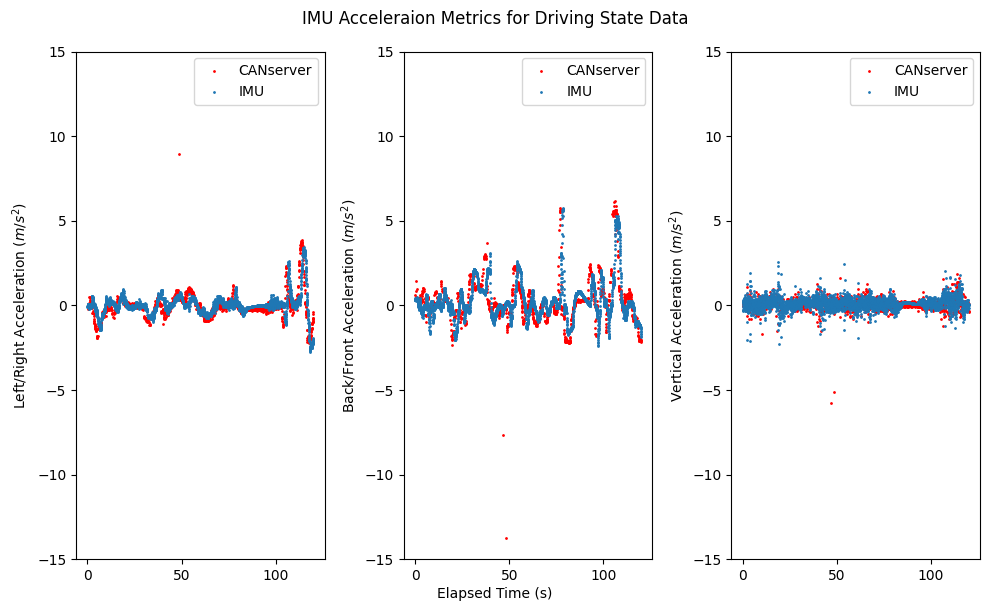

11


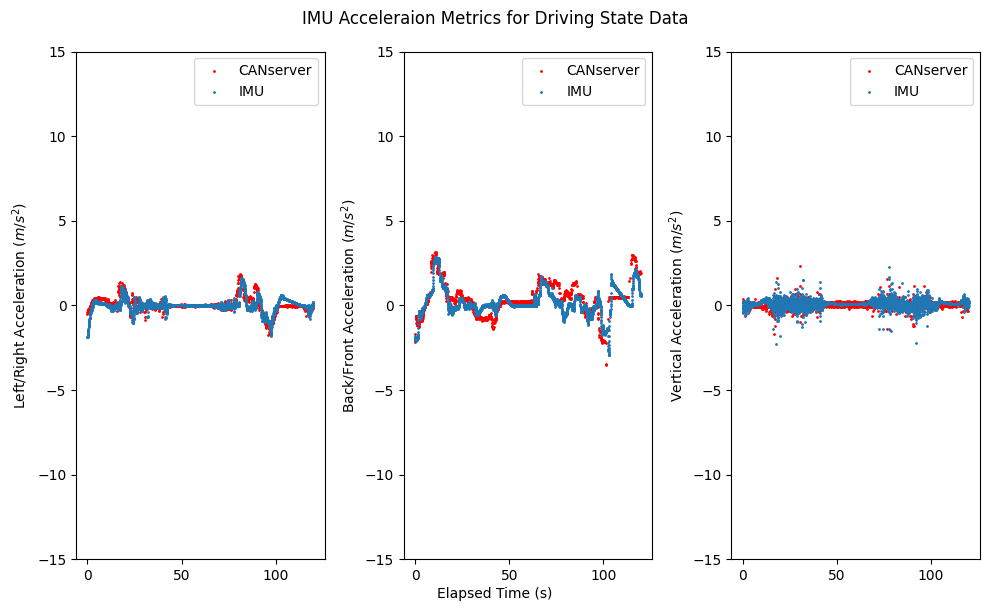

12


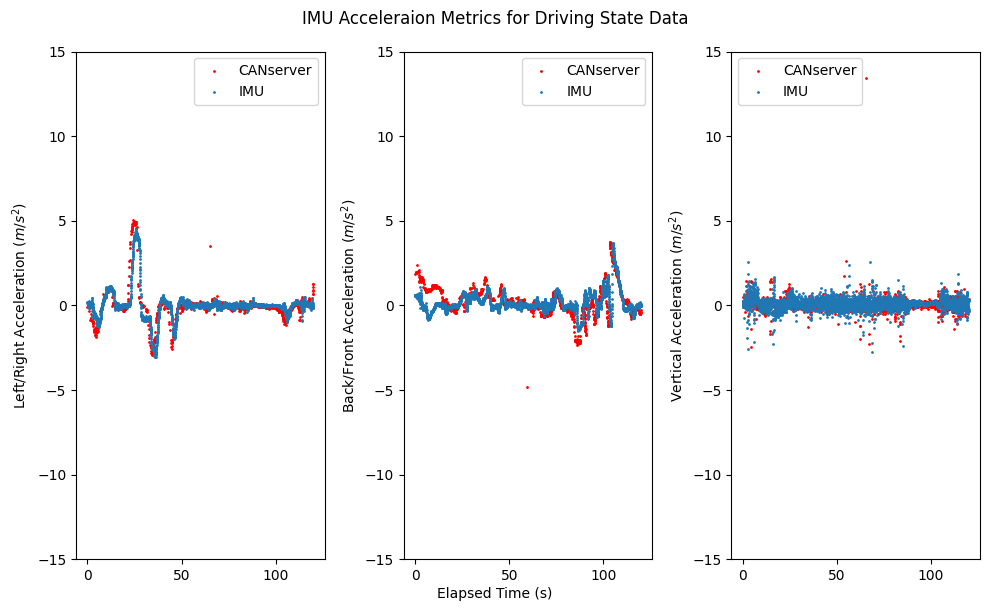

13


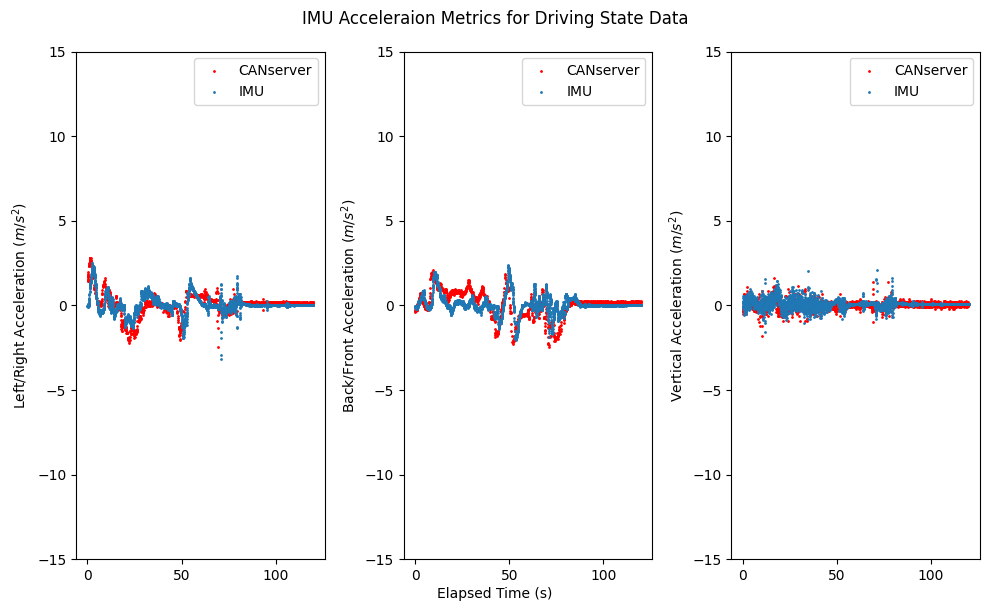

In [21]:
window = 120
count = 0
can_df = can_df[can_df['bf_acc'].notna()]
can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = dr_df[(dr_df['correct_timestamp'] >= dr_start_time) 
                        & (dr_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

1


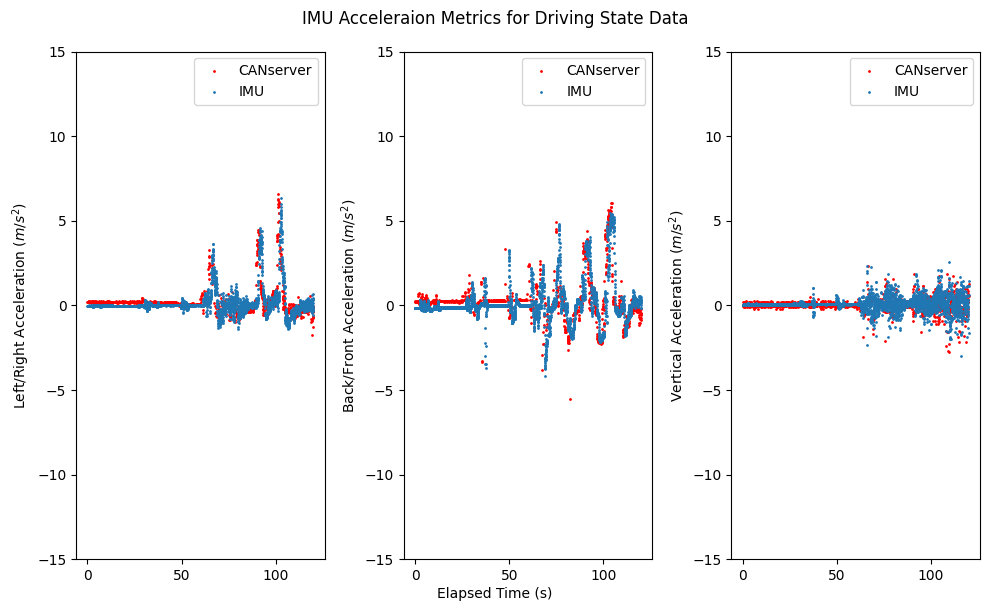

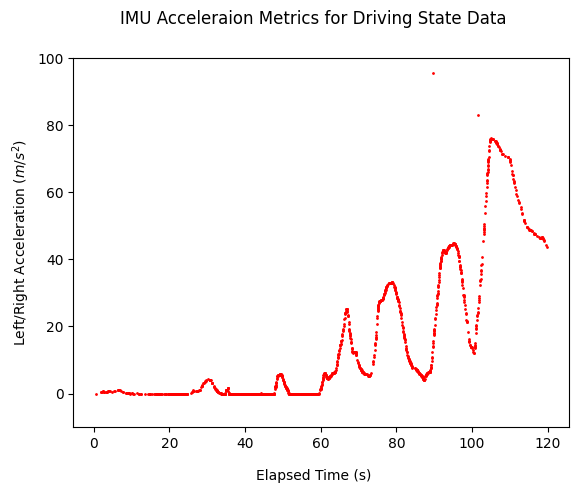

2


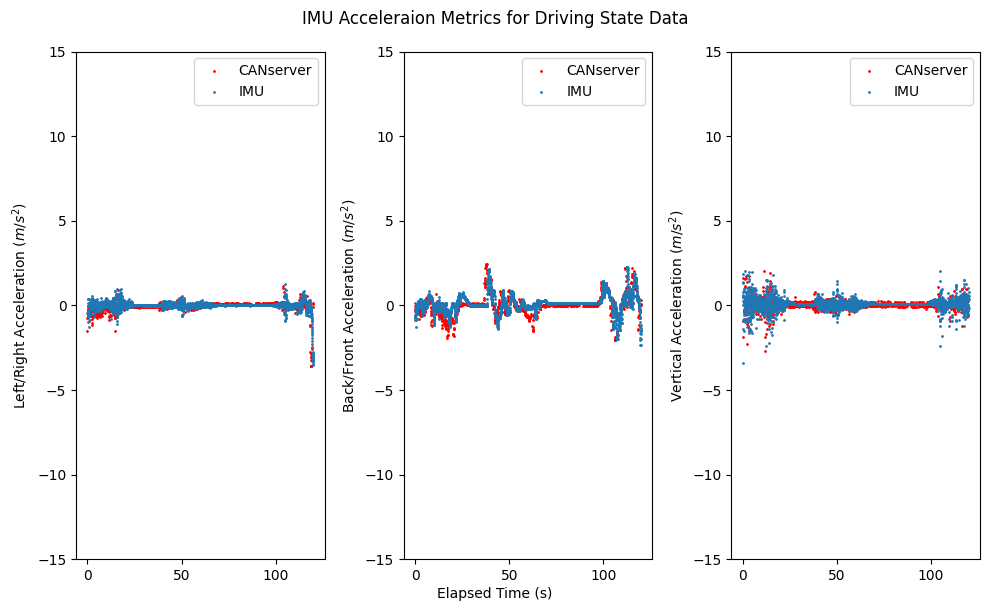

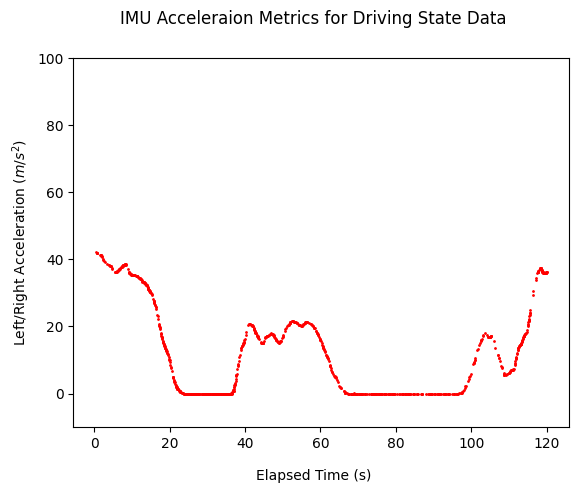

3


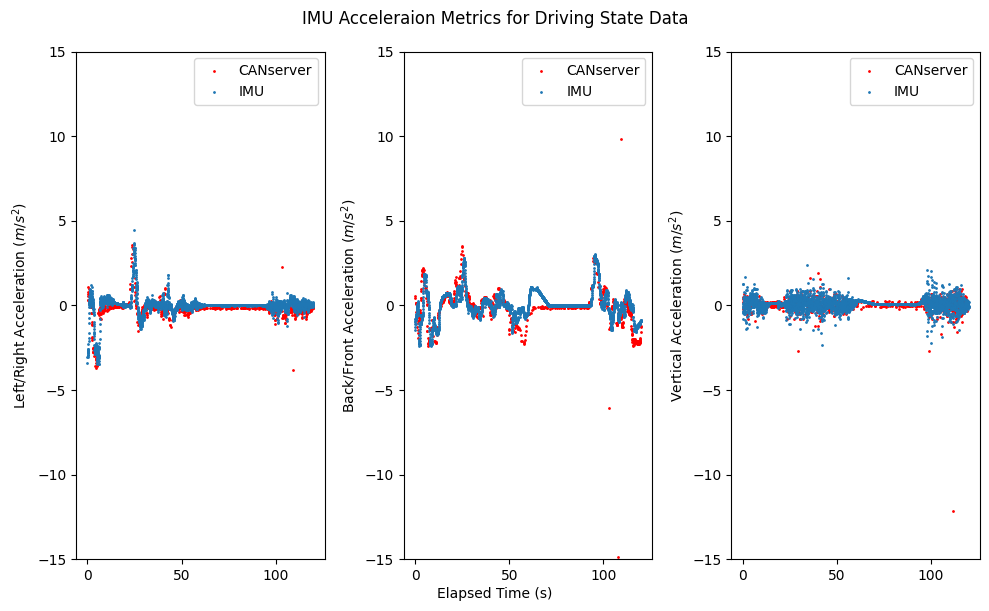

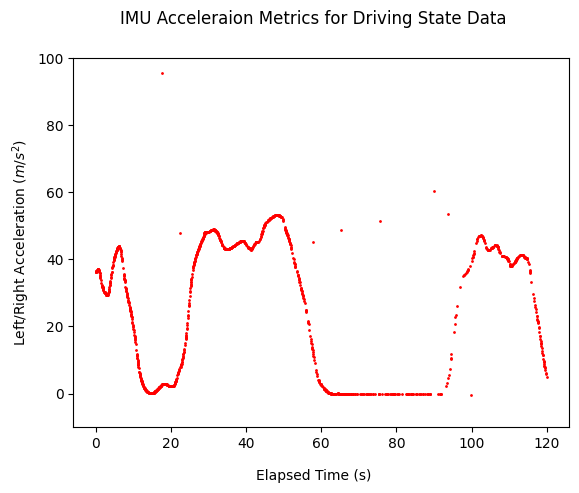

4


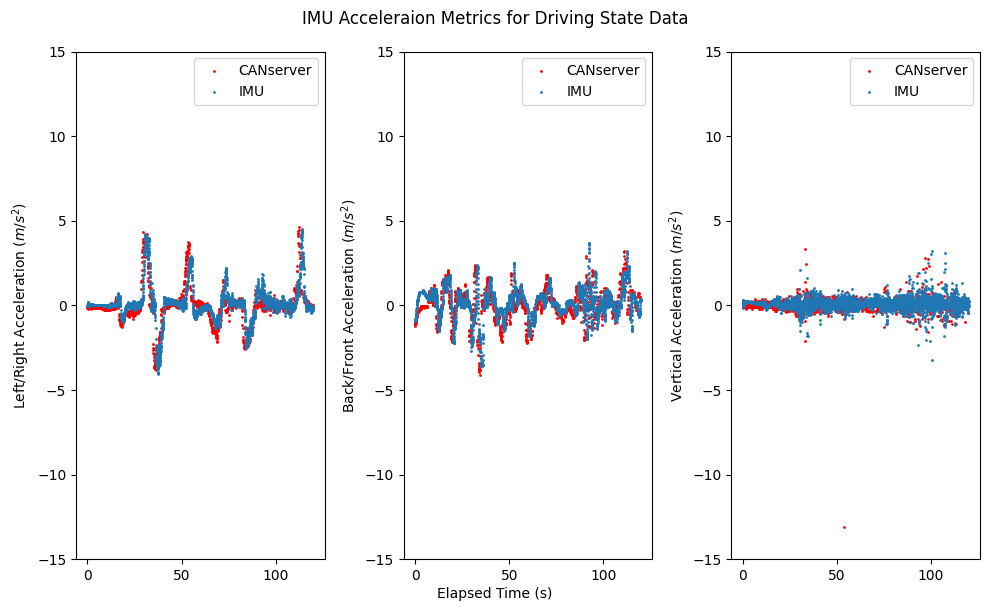

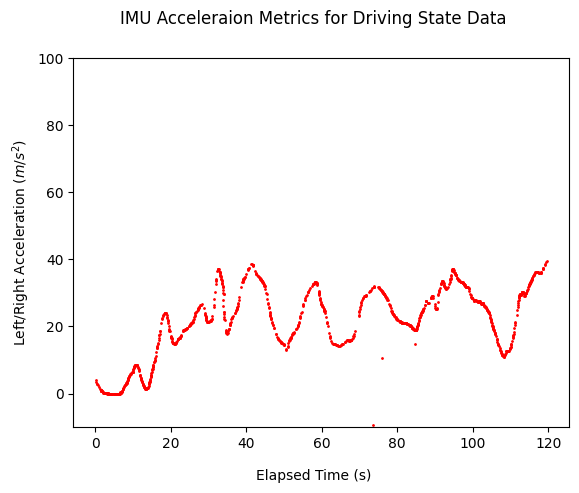

5


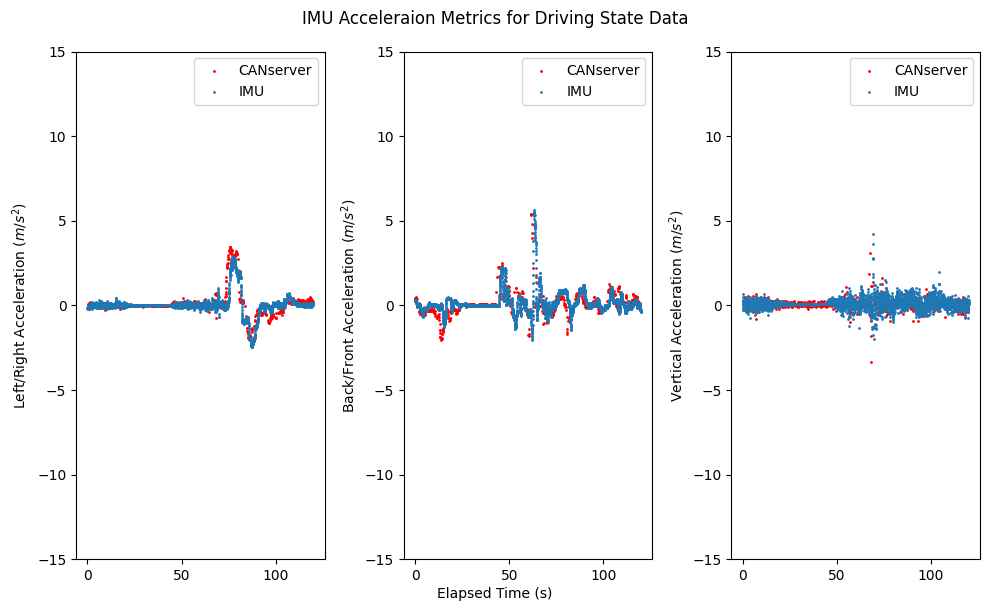

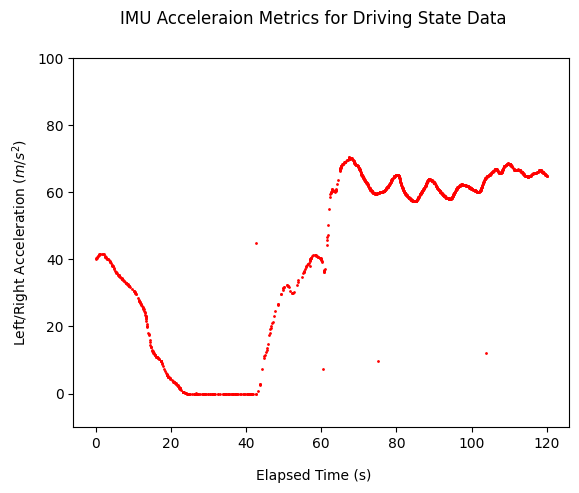

6


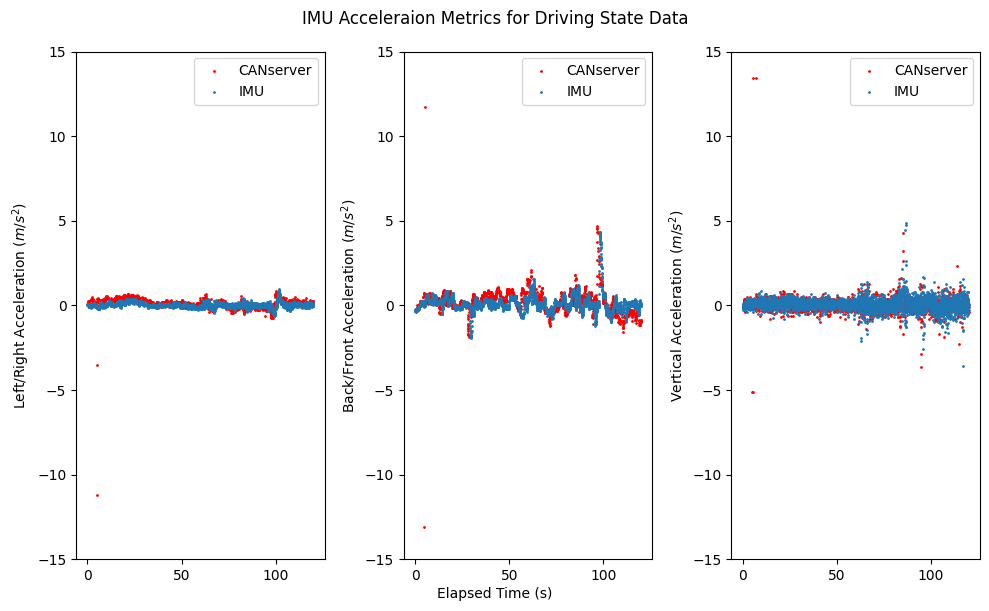

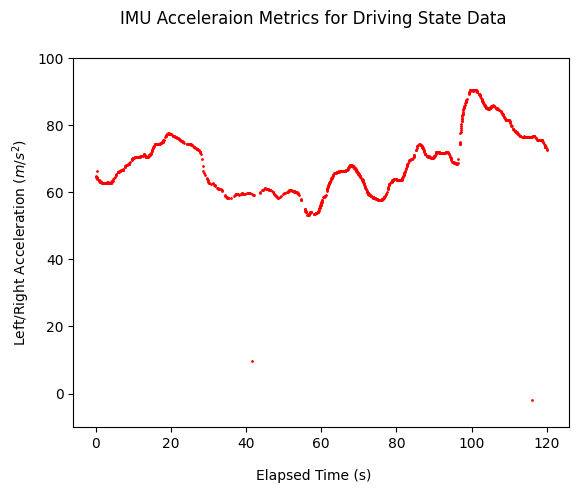

7


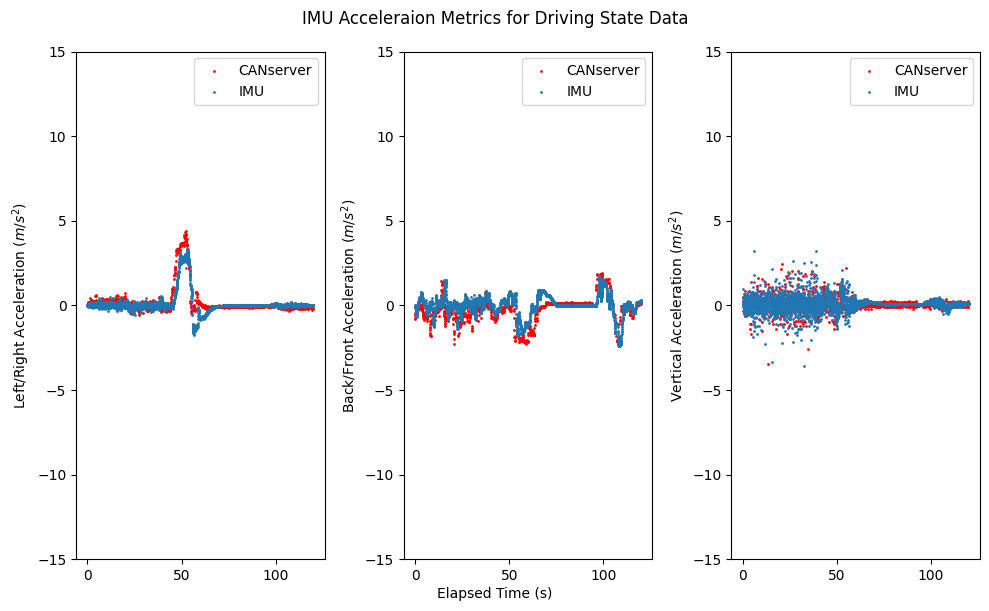

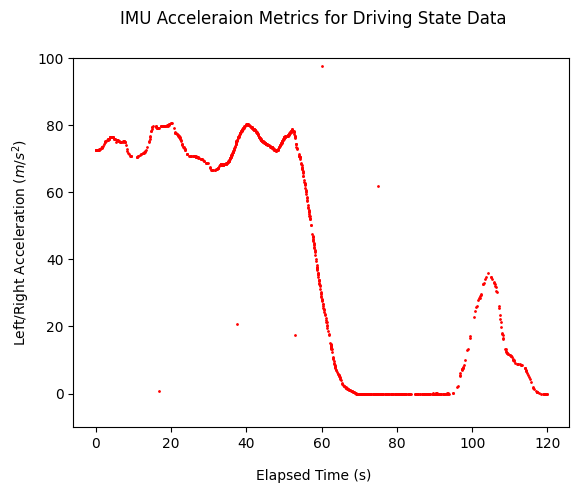

8


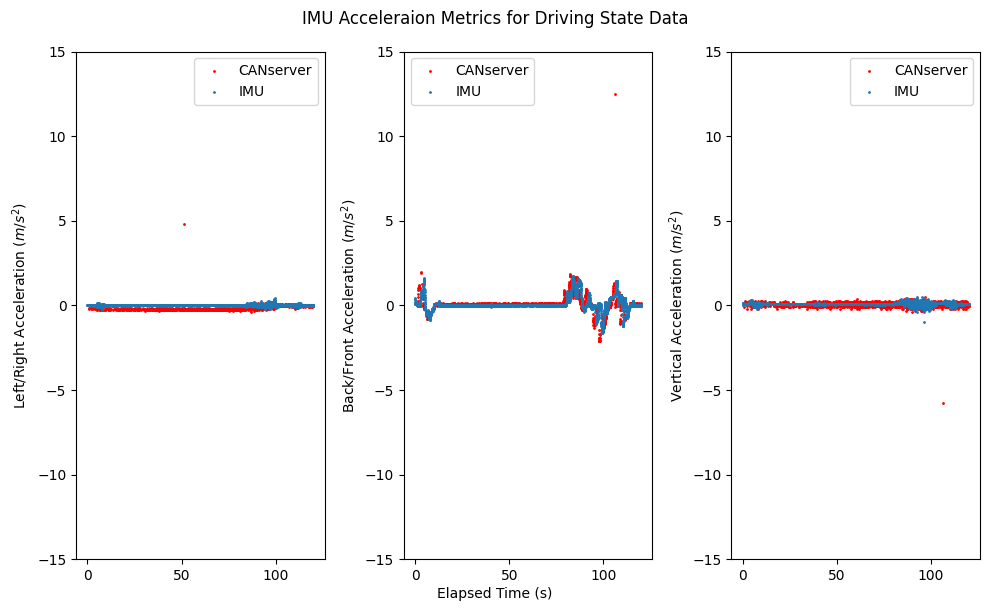

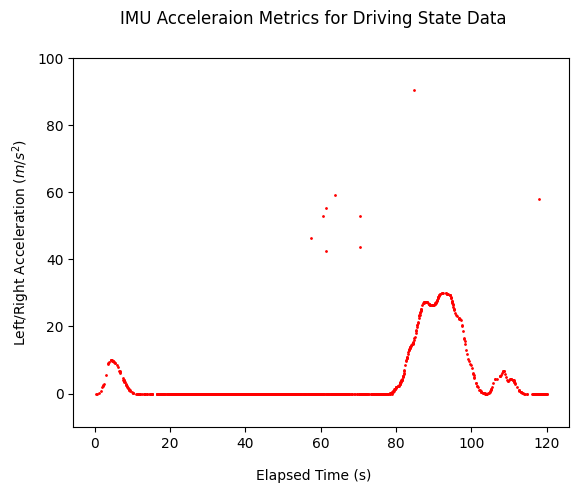

9


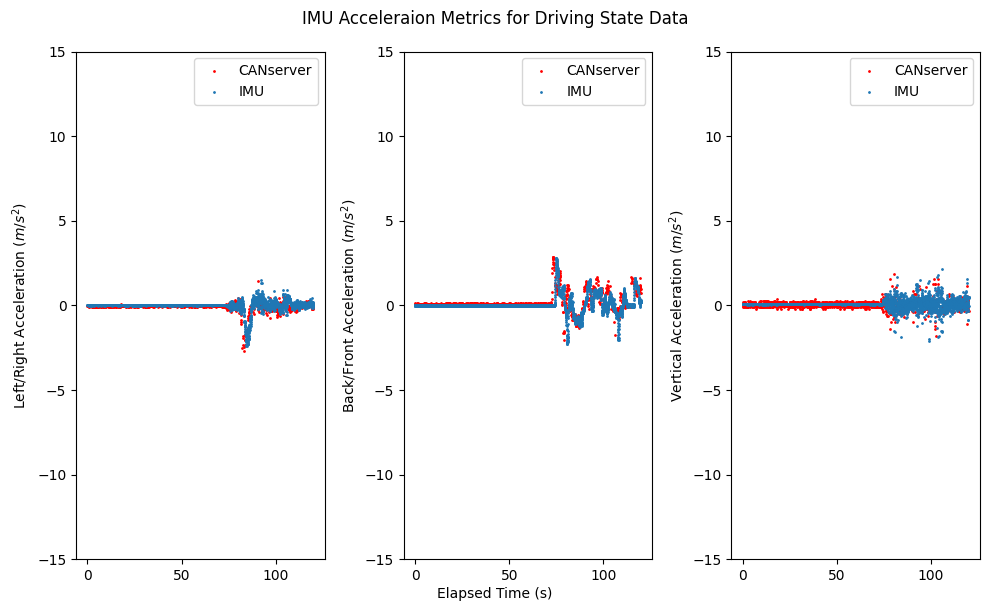

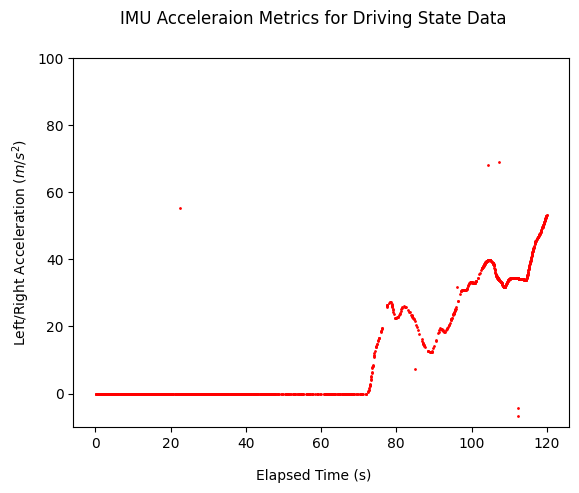

10


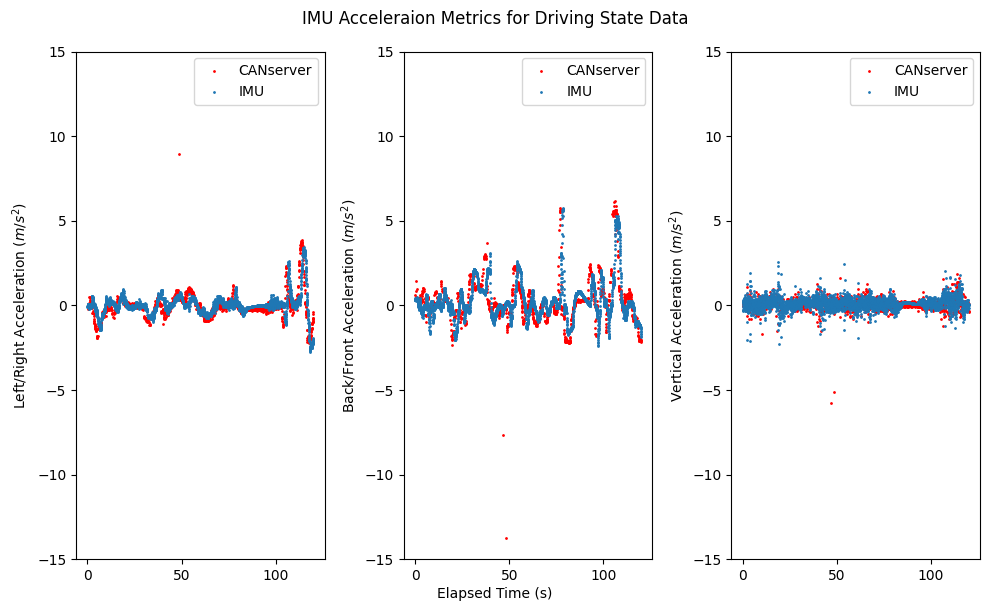

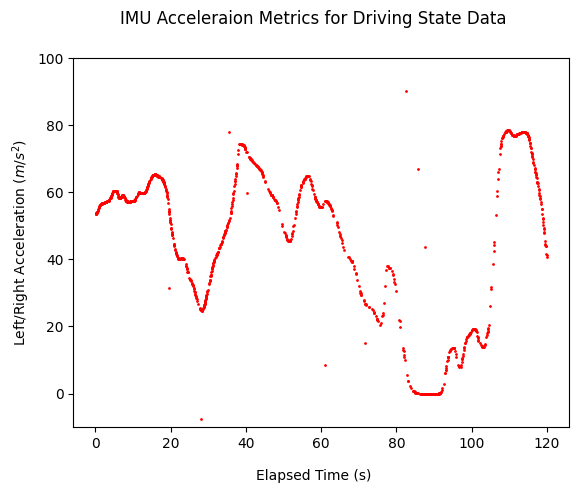

11


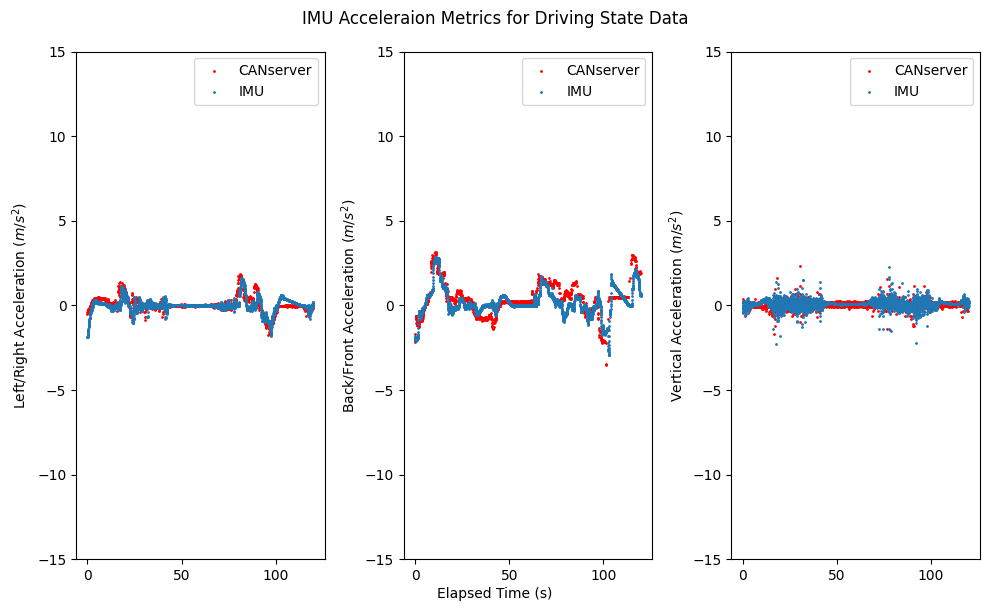

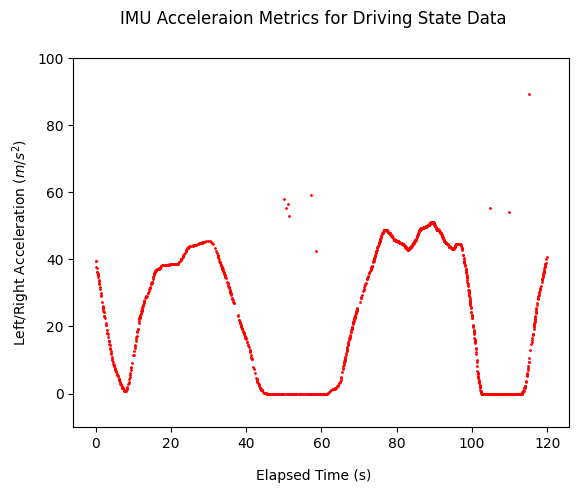

12


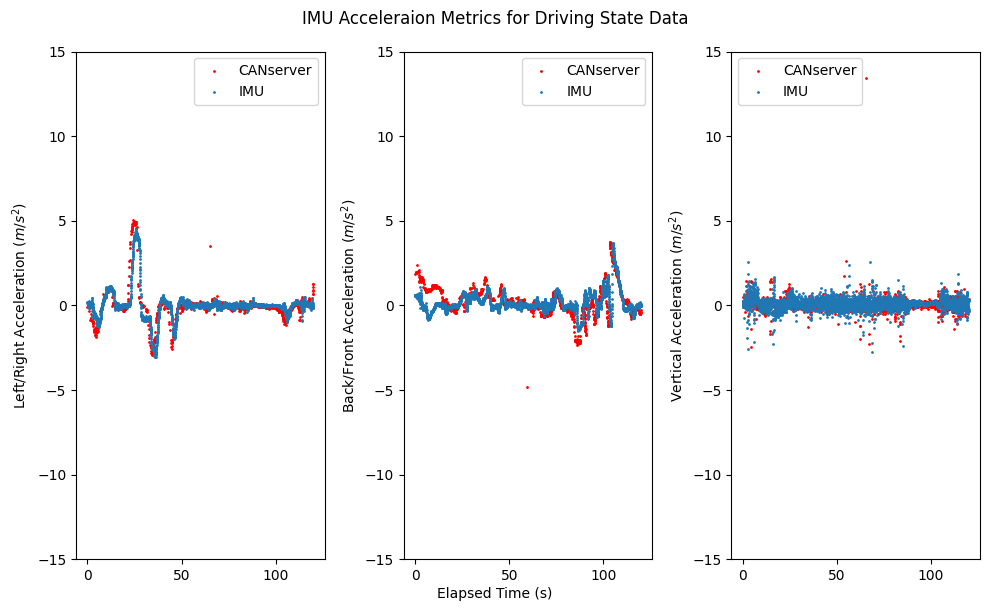

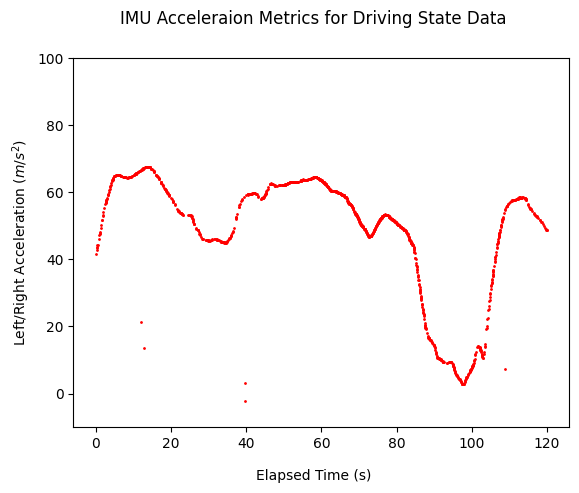

13


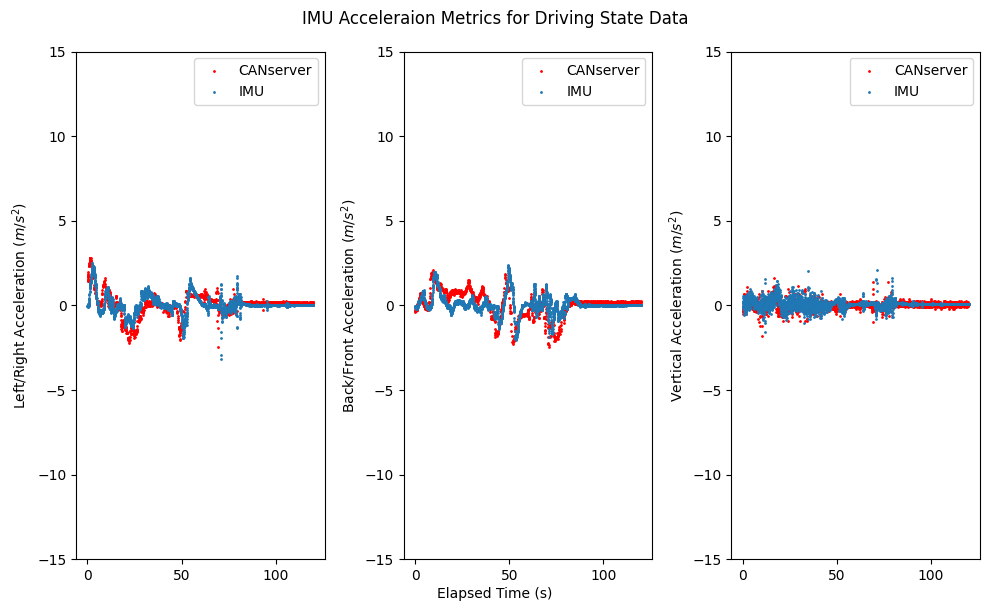

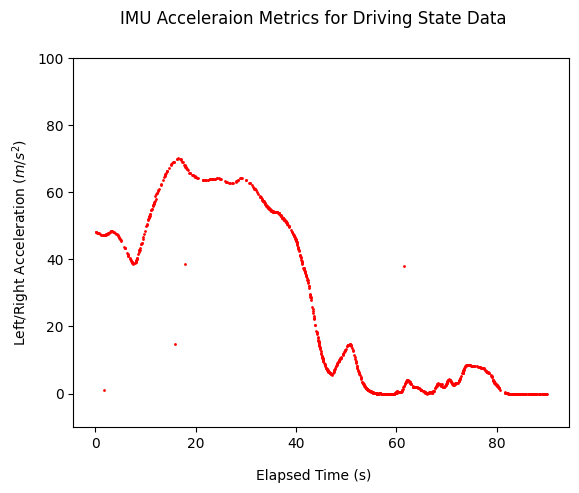

In [17]:
# Check the speed of the car

window = 120
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = imu_df[(imu_df['correct_timestamp'] >= dr_start_time) 
                        & (imu_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()



            fig, ax = plt.subplots()

            ax.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['speed'], s=1, color='red', label='CANserver')
            ax.set_ylim(-10,100)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax.set_ylabel("Left/Right Acceleration ($m/s^2$)")

            plt.show()